## Model initialization

In [24]:
import os
import numpy as np
import keras
from keras.applications import inception_v3
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
import sys
from pylab import rcParams
rcParams["font.size"] = 14
from skimage.segmentation import mark_boundaries
%matplotlib inline
from sklearn.metrics import silhouette_score
print 'Notebook run using keras:', keras.__version__

Notebook run using keras: 2.1.6


In [5]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image, grid_segmentation, evaluation_measures, helper_functions, clustering

In [4]:
model = inception_v3.InceptionV3()

In [5]:
    def transform_img_fn(path_list):
        path_list = sorted(path_list)
        out = []
        for i in range(len(path_list)):
            img = image.load_img(path_list[i], target_size=(299, 299))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = inception_v3.preprocess_input(x)
            out.append(x)
        return np.vstack(out)

In [ ]:
# from datasets import imagenet
# 
# names = imagenet.create_readable_names_for_imagenet_labels()

## Prediction

(299, 299, 3)


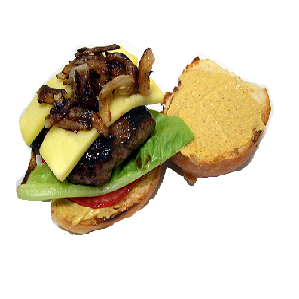

In [6]:
from PIL import Image 
#burger = Image.open("/home/leo/Desktop/ILSVRC2012_val_00002226.jpg")
#burger = burger.resize((299,299))
burger = image.load_img("../../../mini_test/ILSVRC2012_val_00002226.jpg", target_size=(299,299))
print np.array(burger).shape
burger

In [5]:
# sys.path.append('/home/leo/Desktop/Tesi/tf-models/slim')
# from datasets import imagenet
# names = imagenet.create_readable_names_for_imagenet_labels()

(u'n04482393', u'tricycle', 0.965758)
(u'n03623198', u'knee_pad', 0.005162644)
(u'n03877472', u'pajama', 0.00093243003)
(u'n03825788', u'nipple', 0.0006586588)
(u'n04462240', u'toyshop', 0.00049300154)


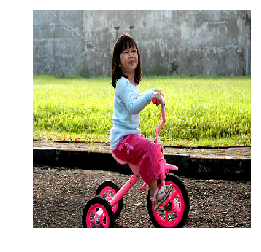

In [25]:
from lime import imagenet_mapping

images = transform_img_fn(['../../../chosen_1000_images/ILSVRC2012_val_00001342.JPEG'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)

plt.axis('off')
preds = model.predict(images)
decoded = decode_predictions(preds)[0]
res = imagenet_mapping.get_imagenet_labels(decoded)
for r in decoded: 
    print r

## Write black box predictions to a file

In [73]:
# %%time
# from lime import imagenet_mapping
# import ntpath
# 
# paths = sorted(helper_functions.absoluteFilePaths("/home/leo/Desktop/Tesi/chosen_1000_images"))
# images = transform_img_fn(paths)
# 
# bb_preds = open("/home/leo/Desktop/predizioni_bb.txt", "w")
# 
# preds = model.predict(images)
# 
# ok=decode_predictions(preds)
# pre = [p[0] for p in ok]
# for p in pre:
#     print p
# 
# res = imagenet_mapping.get_imagenet_labels(pre)
# 
# bb_preds = open("/home/leo/Desktop/predizioni_bb.txt", "w")
# 
# for i in range(len(paths)):
#     row = ntpath.basename( paths[i] ) + " " + res[i][0] + " " + str(res[i][1])
#     bb_preds.write("%s\n" % row)
# bb_preds.close()
# 
# for i in range(len(paths)):
#     res = imagenet_mapping.get_imagenet_labels(decode_predictions(preds)[i][0])
#     
#     print res
#     row = ntpath.basename( paths[i] ) + " " + res[0] + " " + str(res[1])
#     bb_preds.write("%s\n" % row)
#     
# bb_preds.close()

## Explanation with lime sharp (sampling random images)

In [8]:
abs_paths = helper_functions.absoluteFilePaths("../../../chosen_1000_images/")

In [7]:
image_pool = transform_img_fn(abs_paths)
img_to_exp = images

In [ ]:
%%time
from functools import partial

explainer = lime_image.LimeImagePatchworkExplainer(image_pool=image_pool)

explanation = explainer.explain_instance(images[0], 
                                         model.predict, 
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=100,
                                         segmentation_fn=partial(grid_segmentation.gridSegmentation,8))

## Explanation with lime (turning off superpixels)

In [26]:
%%time
classic_explainer = lime_image.LimeImageExplainer(verbose=False)

classic_explanation,sam = classic_explainer.explain_instance(images[0], 
                                                         model.predict, 
                                                         top_labels=1, 
                                                         hide_color=0, 
                                                         num_samples=100,
                                                         return_sample_neighborhood_images=True)

CPU times: user 2min 53s, sys: 9.98 s, total: 3min 3s
Wall time: 25.9 s


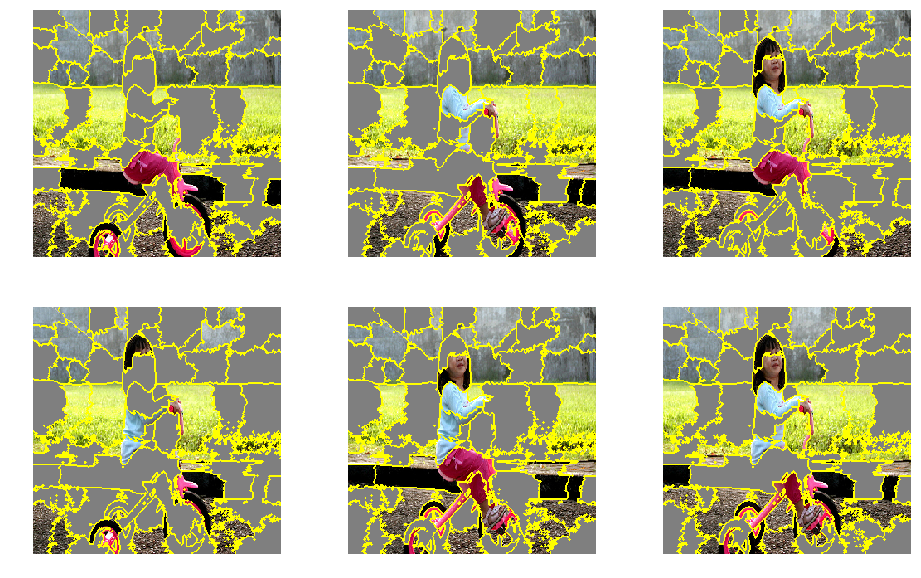

In [43]:
helper_functions.grid_plot(\
    [mark_boundaries(s/2 + 0.5, classic_explanation.segments) for s in sam][:6], (2,3), size_of_figures=(16,10))

(-0.5, 298.5, 298.5, -0.5)

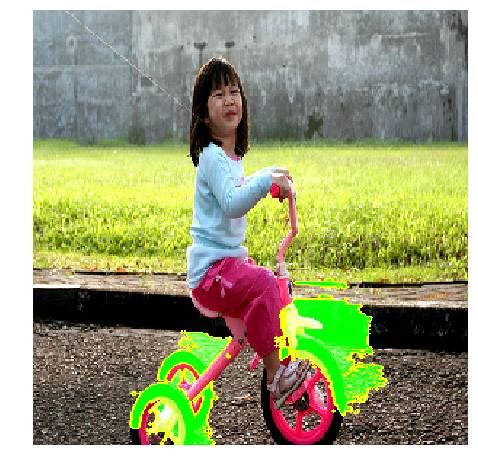

In [60]:
label_to_exp = 870

temp_classic, mask_classic = classic_explanation.get_image_and_mask(label_to_exp, positive_only=True, 
                                                                    num_features=4, hide_rest=False)
classic_image = (mark_boundaries(temp_classic/2+0.5, mask_classic))

plt.figure(figsize=(8,8))
plt.imshow(classic_image)
plt.axis('off')

In [11]:
label_to_exp = 933

similarity between explanations is 0.25


<Figure size 432x288 with 0 Axes>

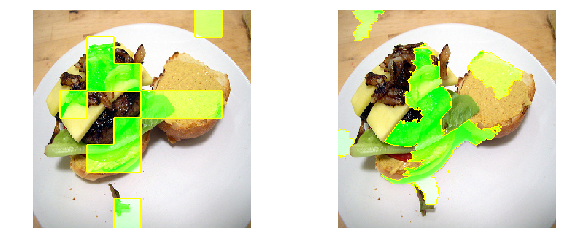

In [12]:
from skimage.segmentation import mark_boundaries

shown_features = 12

temp, mask = explanation.get_image_and_mask(label_to_exp, positive_only=True, 
                                            num_features=shown_features, hide_rest=False)
grid_image = (mark_boundaries(temp/2+0.5, mask))
plt.figure()

temp_classic, mask_classic = classic_explanation.get_image_and_mask(label_to_exp, positive_only=True, 
                                                                    num_features=shown_features, hide_rest=False)
classic_image = (mark_boundaries(temp_classic/2+0.5, mask_classic))

segments = grid_segmentation.gridSegmentation(8, img_to_exp[0])

similarity = evaluation_measures.compare_explanations(mask_classic, mask, grid_segmentation.get_blocks_coordinates(segments))
print "similarity between explanations is %.2f" % similarity

helper_functions.grid_plot([grid_image, classic_image], (1,2), size_of_figures=(10,4))

In [13]:
highlighted_features = [area[0] for area in explanation.local_exp[933] if area[1] > 0][:shown_features]
lime_highlighted_features = [area[0] for area in classic_explanation.local_exp[933] if area[1] > 0][:shown_features]

In [16]:
res = evaluation_measures.relative_quality_of_explanation(np.array(burger), 
                                                          highlighted_features, 
                                                          explanation.segments)
res_lime = evaluation_measures.relative_quality_of_explanation(np.array(burger), 
                                                      lime_highlighted_features, 
                                                      classic_explanation.segments)

print res, res_lime

0.833333333333 0.75


In [17]:
abs_res = evaluation_measures.absolute_quality_of_explanation(np.array(burger), 
                                                          highlighted_features, 
                                                          explanation.segments)
abs_res_lime = evaluation_measures.absolute_quality_of_explanation(np.array(burger), 
                                                      lime_highlighted_features, 
                                                      classic_explanation.segments)

print abs_res, abs_res_lime

0.398184450208 0.348875082936


## Clustering with K-means (downsizing images)

In [6]:
sys.path.append('../../lime')
import clustering

In [7]:
path_of_imgs = helper_functions.absoluteFilePaths('../../../chosen_1000_images_resized')

In [8]:
images = clustering.load_images(path_of_imgs)

In [53]:
results = []
silhouettes = []
for k in range(2, 201, 20):
    compactness, labels, centers = clustering.k_means(flattened, k)
    results.append((compactness, labels, centers))
    silhouettes.append(silhouette_score(flattened, labels))

In [54]:
sses = [r[0] for r in results]
x = range(2, 201, 20)

In [55]:
diffs=[]
for i in range(1, len(sses)):
    diffs.append(abs(sses[i] - sses[i-1]))

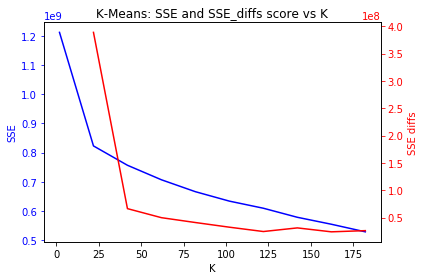

In [71]:
# first axis
fig, ax1 = plt.subplots()
ax1.plot(x, sses, 'b')
ax1.set_xlabel('K')
ax1.set_ylabel('SSE', color='b')
ax1.tick_params('y', colors='b')
# second axis
ax2 = ax1.twinx()
ax2.plot(x[1:],diffs, 'r')
ax2.set_ylabel('SSE diffs', color='r')
#ax2.plot(range(36, len(results)+35),diffs, 'r')
#ax2.set_ylabel('SSE_diffs', color='r')
ax2.tick_params('y', colors='r')

plt.title('K-Means: SSE and SSE_diffs score vs K')
fig.tight_layout()
plt.show()

In [57]:
zip(range(2, 201, 20), sses)

[(2, 1211659699.0034168),
 (22, 822751440.5161344),
 (42, 756490312.3082801),
 (62, 706783924.8970915),
 (82, 665957647.4929601),
 (102, 633671152.9656769),
 (122, 609313159.0358936),
 (142, 578315869.191648),
 (162, 554507650.7216346),
 (182, 528516912.4724325)]

In [59]:
chosen_k = 22
compactness, labels, centers = clustering.k_means(flattened, chosen_k)

In [32]:
centers[0].shape, flattened[99].shape

((768,), (768,))

In [60]:
def sse(vect1, vect2):
    return np.linalg.norm(vect1-vect2)

In [61]:
errors_in_each_cluster = []
for cluster in range(chosen_k):
    imgs_of_clus = []
    for i in range(len(flattened)):   
        if labels[i] == cluster:
            imgs_of_clus.append(flattened[i])
    c = centers[cluster]

    sse_of_clus = [sse(im,c) for im in imgs_of_clus]
    errors_in_each_cluster.append(np.mean(sse_of_clus))

tmp = zip(range(chosen_k), errors_in_each_cluster)
results = sorted(tmp, key=lambda x: x[1])
chosen_clusters = [r for r in results if r[1] > 0][:6]
print chosen_clusters

[(17, 569.79254), (5, 776.3515), (21, 793.36804), (18, 807.25287), (8, 821.95917), (1, 841.12085)]


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


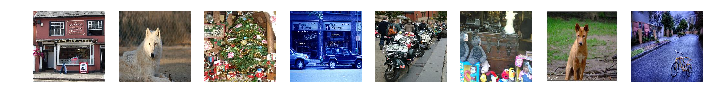

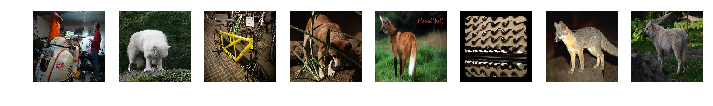

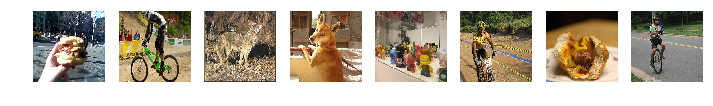

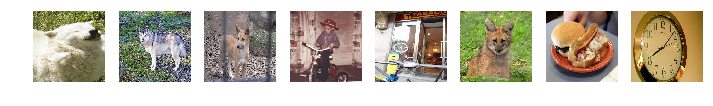

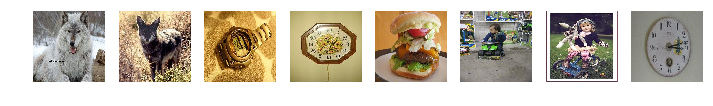

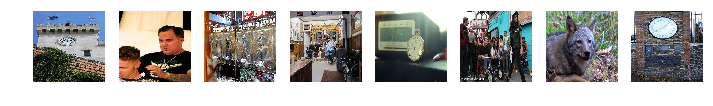

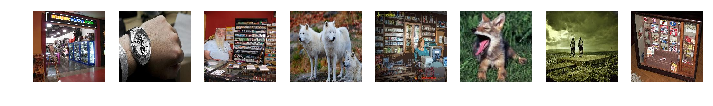

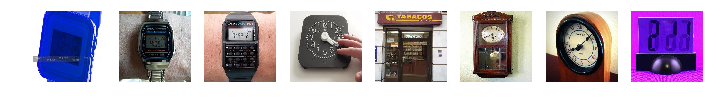

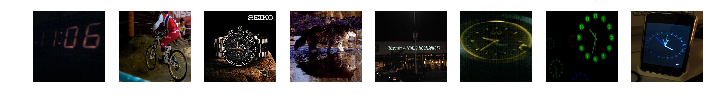

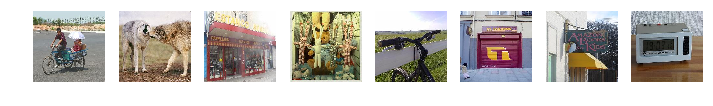

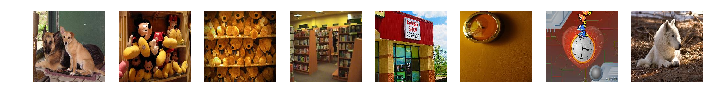

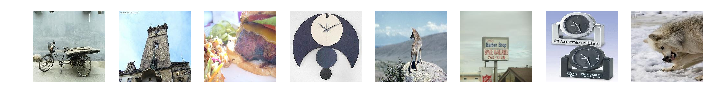

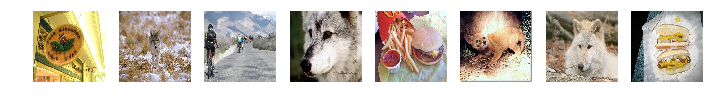

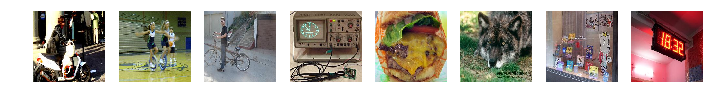

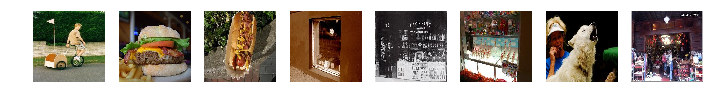

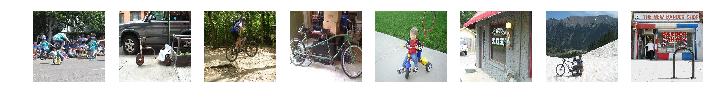

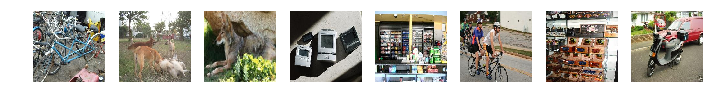

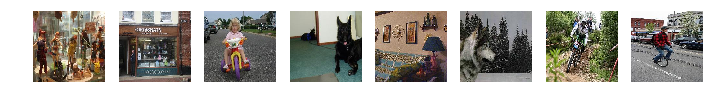

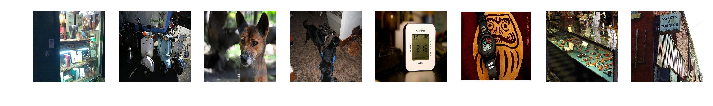

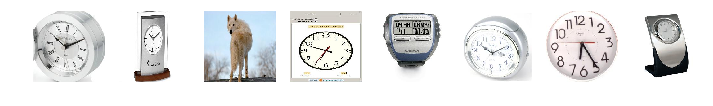

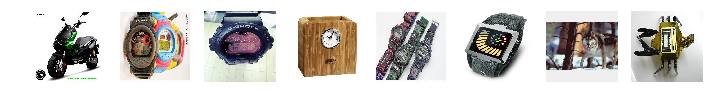

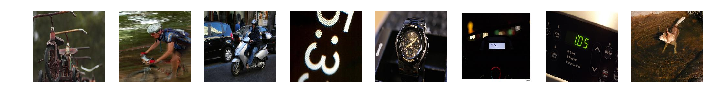

In [69]:
import random
for cluster in random.sample(range(22), 22):#chosen_clusters:
    clus_imgs = [images[i] for i in range(len(images)) if labels[i] == cluster]#cluster[0]
    helper_functions.grid_plot(clus_imgs[:8], (1,8), size_of_figures=(12,6))

## Clustering with K-means (blurred images)

In [8]:
import cv2

blurred = [cv2.blur(im,(30,30)) for im in imgs]
blurred_flat = clustering.flatten_images(blurred)

results = []
for k in range(15,35):
    compactness, labels, centers = clustering.k_means(blurred_flat, k)
    results.append((compactness, labels, centers))

In [9]:
sses = [r[0] for r in results]
x = range(15, len(results)+15)

In [10]:
diffs=[]
for i in range(1, len(sses)):
    diffs.append(abs(sses[i] - sses[i-1]))

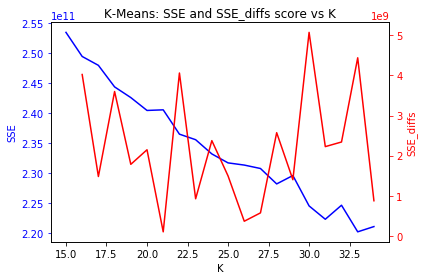

In [11]:
# first axis
fig, ax1 = plt.subplots()
ax1.plot(x, sses, 'b')
ax1.set_xlabel('K')
ax1.set_ylabel('SSE', color='b')
ax1.tick_params('y', colors='b')
# second axis
ax2 = ax1.twinx()
ax2.plot(range(16, len(results)+15),diffs, 'r')
ax2.set_ylabel('SSE_diffs', color='r')
ax2.tick_params('y', colors='r')

plt.title('K-Means: SSE and SSE_diffs score vs K')
fig.tight_layout()
plt.show()

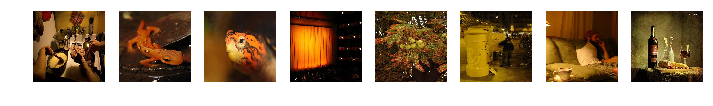

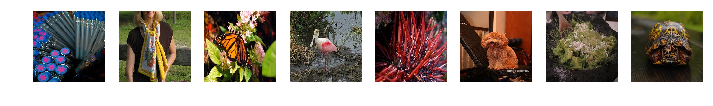

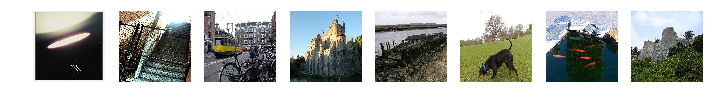

In [12]:
cluster_num_4 = [imgs[i] for i in range(len(imgs)) if labels[i] == 4]
cluster_num_13 = [imgs[i] for i in range(len(imgs)) if labels[i] == 13]
cluster_num_20 = [imgs[i] for i in range(len(imgs)) if labels[i] == 20]
helper_functions.grid_plot(cluster_num_4[:8], (1,8), size_of_figures=(12,6))
helper_functions.grid_plot(cluster_num_13[:8], (1,8), size_of_figures=(12,6))
helper_functions.grid_plot(cluster_num_20[:8], (1,8), size_of_figures=(12,6))

## Spectral clustering

In [9]:
und = clustering.undersample_images(images, 8)
flattened = clustering.flatten_images(und)

/usr/local/lib/python2.7/dist-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


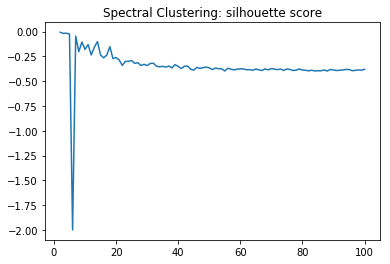

In [10]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

silhouettes = []
    
for cl in range(2,101):
    try:
        labels = SpectralClustering(n_clusters=cl, n_jobs=-1).fit_predict(flattened)
        silhouettes.append(silhouette_score(flattened, labels))
    except:
        silhouettes.append(-2)

X = range(2,101)

plt.title("Spectral Clustering: silhouette score")
plt.plot(X,silhouettes)
plt.show()

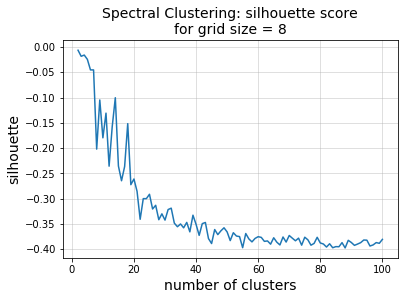

In [30]:
X = range(2,101)

for i in range(len(silhouettes)):
    if silhouettes[i] == None:
        silhouettes[i] = -0.045

plt.title("Spectral Clustering: silhouette score\nfor grid size = 8", fontsize=14)
plt.plot(X,silhouettes)
plt.ylabel("silhouette", fontsize=14)
plt.grid(alpha=0.5)
plt.xlabel("number of clusters", fontsize=14)
plt.show()

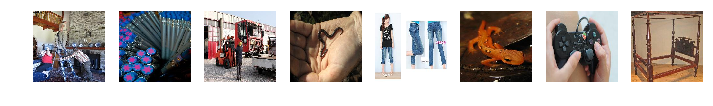

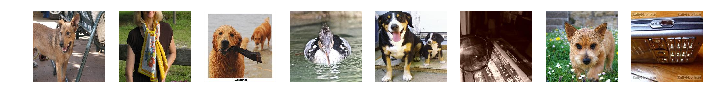

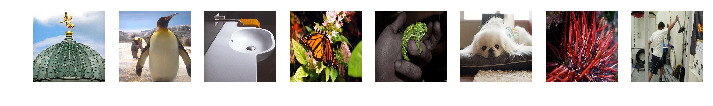

In [19]:
cluster_num_4 = [imgs[i] for i in range(len(imgs)) if labels[i] == 4]
cluster_num_2 = [imgs[i] for i in range(len(imgs)) if labels[i] == 2]
cluster_num_5 = [imgs[i] for i in range(len(imgs)) if labels[i] == 5]
helper_functions.grid_plot(cluster_num_4[:8], (1,8), size_of_figures=(12,6))
helper_functions.grid_plot(cluster_num_2[:8], (1,8), size_of_figures=(12,6))
helper_functions.grid_plot(cluster_num_5[:8], (1,8), size_of_figures=(12,6))

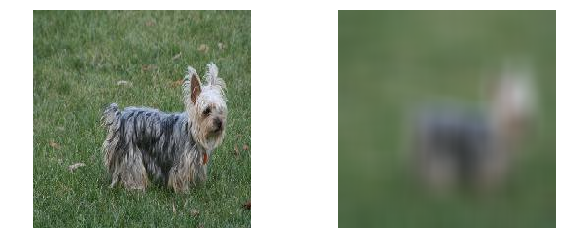

In [106]:
import cv2

blur = cv2.blur(imgs[2],(30,30))
helper_functions.grid_plot([imgs[2], blur], (1,2))